# Resonant neuron (Type 2)

## without adaptaion saddle-node depolarization block
$$
\begin{array}{rll}
L_1(v,v_3,r_0,r_1,0)       &\dot{v}&=P_{32}(v,v_0,v_2)L_1(v,v_0,a_0,a_1,0)+I-w^2\\
S_2(v,v_6,,v_7,s_0,s_1,s_2)&\dot{w}&=L_2(v,v_4,0,v_5,1,0,0)-w
\end{array}
$$

In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from scipy.integrate import odeint
import sympy
from pls import *
v0,v2 = -65., 55.
a0,a1    = 3.25e-6,-1e-4 #a2 = 0.
#--- \tau_v
v3       = -35.
r0,r1    = 0.04, -0.004 #r2 = 0.
#--- n_\infty
v4,v5    = -75.,-5.
#--- \tau_n
v6,v7    = -55.5,18.
s0,s1,s2 = 5.,7.6,1.8
wp       = 2

In [2]:
symV, symW, symI = sympy.symbols('v w I')

def getroots(I):
    vm    = linspace(v4-1.,v2+1.,int(v2-v4)*1000+1002)
    vnull = vectorize(P32)(vm,v0,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I
    wnull = vectorize(L2)(vm,v4,0.,v5,1.,0.,0.)
    if   wp == 4: vnull = sqrt(sqrt(vnull))
    elif wp == 2: vnull = sqrt(     vnull )
    numidx= where(~isnan(vnull))[0]
    nDel  = vnull[numidx]-wnull[numidx]
    idx = where((nDel[:-1]>0.)*(nDel[1:]<=0.)+(nDel[:-1]<=0.)*(nDel[1:]>=0.))[0]
    if   len(idx) > 2:
        idx = [idx[0]]+[l2 for l1,l2 in zip(idx[:-1],idx[1:]) if l1+1 != l2]
    elif len(idx) == 0:
        #DB>>
        raise Exception("empty index")
        #<<DB
    return vm[numidx[idx]],vectorize(L2)(vm[numidx[idx]],v4,0.,v5,1.,0.,0.)

def getJacobian(v,w,I):
    #vrhs = (symP32(symV,v,v0,v2)*symL1(symV,v,v0,a0,a1,0.)+symI-symW**4)/symL1(symV,v,v3,r0,r1,0.)
    vrhs = (symP32(symV,v,v0,v2)*symL1(symV,v,v0,a0,a1,0.)+symI-symW**wp   )/symL1(symV,v,v3,r0,r1,0.)
    wrhs = (symL2(symV,v,v4,0.,v5,1.,0.,0.)-symW)/symS2(symV,v,v6,v7,s0,s1,s2)
    dvdv, dvdw = vrhs.diff(symV),vrhs.diff(symW)
    dwdv, dwdw = wrhs.diff(symV),wrhs.diff(symW)
    return array([
        [dvdv.subs(symV,v).subs(symW,w).subs(symI,I),dvdw.subs(symV,v).subs(symW,w).subs(symI,I)],
        [dwdv.subs(symV,v).subs(symW,w).subs(symI,I),dwdw.subs(symV,v).subs(symW,w).subs(symI,I)]
    ])

def getStability(I,verb=False):
    vx,wx = getroots(I)
    ret = []
    for v,w in zip(vx,wx):
        #print("vwi",v,w,I)
        m = getJacobian(v,w,I)
        #print("m",m.tolist())
        if verb:
            print("=== FIX POINT ===")
            print(" > V*={:0.2f} W*={:0.2f}".format(v,w))
            #print(" > tau={:0.2f} det={:0.2f}".format(m[0,0]+m[1,1], m[0,0]*m[1,1]-m[1,0]*m[0,1]))
        ev, eV = linalg.eig(m.astype(complex))
        if verb:
            print(ev)
            print(eV)
        ret.append( (v,w,ev,eV))
    return ret
i,ic = 0.,0.
ret = getStability(i)
for pwr in range(-1,-9,-1):
    ibase = ic
    for n in range(0,10):
        ic = i
        i  = ibase + n*10**pwr
        ret = getStability(i)
    
        if len(ret) != 1:
            print(ret)
            raise Exception(f"Cannot detect a single fixed point at {i}")
        v,w,ev,eV = ret[0]
        if ev[0].real > 0.: break
    else:
        ic = ibase + 9*10**pwr
        i  = ic

I0=ic
ic=i
for pwr in range(-1,-9,-1):
    ibase = ic
    for n in range(0,10):
        ic = i
        i  = ibase + n*10**pwr
        ret = getStability(i)
    
        if len(ret) != 1:  break
        v,w,ev,eV = ret[0]
        if ev[0].real < 0.: break
    else:
        ic = ibase + 9*10**pwr
        i  = ic
I1=(i+ic)/2
print(f"I0={I0}, I1={I1}")

<ipython-input-2-bb42a5087c7d>:8: RuntimeWarning: invalid value encountered in sqrt
  elif wp == 2: vnull = sqrt(     vnull )


I0=0.05299323, I1=0.168000005


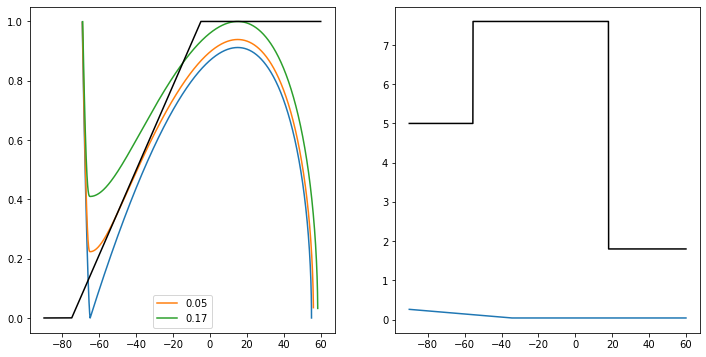

In [3]:
vm = linspace(-90,60,6001)
I0 = 0.05
def safesqrt(x,y,limit=None):
    if limit is None:
        if   wp == 4:
            return column_stack((x[where(y>=0.)],sqrt(sqrt(y[where(y>=0.)]))))
        elif wp == 2:
            return column_stack((x[where(y>=0.)],     sqrt(y[where(y>=0.)] )))
        else:
            return column_stack((x[where(y>=0.)],          y[where(y>=0.)]  ))
    else:
        z = safesqrt(x,y)
        return z[where(z[:,1]<limit)]

v0c    = safesqrt(vm, vectorize(P32)(vm,v0,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+0. ,1)
v0cI0  = safesqrt(vm, vectorize(P32)(vm,v0,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I0 ,1)
v0cI1  = safesqrt(vm, vectorize(P32)(vm,v0,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I1 ,1)

f1=figure(1,figsize=(12,6))
subplot(121)
plot(v0c[:,0],v0c[:,1])
#for i in arange(0.,0.05,0.01).tolist()+[0.1,0.3,0.6]:
#    xV = safesqrt(vm, vectorize(P32)(vm,v0,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+i ,1) 
#    plot(xV[:,0], xV[:,1],label='{:0.2g}'.format(i))
plot(v0cI0[:,0], v0cI0[:,1],label='{:0.2g}'.format(I0))
plot(v0cI1[:,0], v0cI1[:,1],label='{:0.2g}'.format(I1))
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
legend(loc=0)
#xlim(-55,-35)
#ylim(0.2,0.6)

subplot(122)
plot(vm,vectorize(L1)(vm,v3,r0,r1,0.))
plot(vm,vectorize(S2)(vm,v6,v7,s0,s1,s2),"k-")
f1.savefig("pls-t2-nulls-saddlenode-depblk.svg")
f1.savefig("pls-t2-nulls-saddlenode-depblk.png")
show()

In [4]:
def getCurr(t):
    if          t <  500: return I0
    elif 500 <= t < 9000: return I0*1.057
    else                : return I1*(0.9+0.2*(t-9000)/1000)
def t2rhs(Y,t):
    v,w = Y
    return[
        (P32(v,v0,v2)*L1(v,v0,a0,a1,0.)+getCurr(t)-w**wp)/L1(v,v3,r0,r1,0.),
        (L2(v,v4,0.,v5,1.,0.,0.)-w)/S2(v,v6,v7,s0,s1,s2)
    ]
I = (I1-I0)/(10000-250)
at = arange(0,10000,0.01)
res = odeint(t2rhs,[-50.,0.35],at)

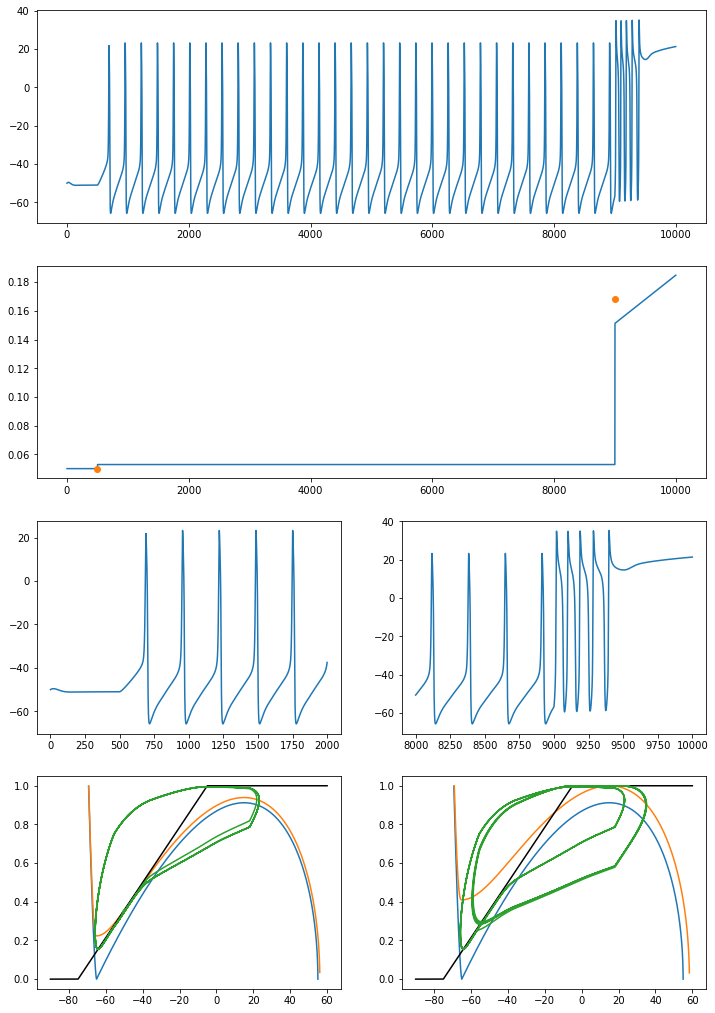

In [5]:
f2 = figure(2, figsize=(12,18))
subplot2grid((4,2),(0,0),colspan=2)
plot(at,res[:,0])
subplot2grid((4,2),(1,0),colspan=2)
plot(at,vectorize(getCurr)(at))
plot([500.,9000.],[I0,I1],'o')

subplot2grid((4,2),(2,0))
plot(at[:200000],res[:200000,0])
subplot2grid((4,2),(2,1))
plot(at[-200000:],res[-200000:,0])
subplot2grid((4,2),(3,0))
plot(v0c[:,0],v0c[:,1])
plot(v0cI0[:,0],v0cI0[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[:200000,0],res[:200000,1])
subplot2grid((4,2),(3,1))
plot(v0c[:,0],v0c[:,1])
plot(v0cI1[:,0],v0cI1[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[-200000:,0],res[-200000:,1])
f2.savefig("pls-t2-ramp-saddlenode-depblk.svg")
f2.savefig("pls-t2-ramp-saddlenode-depblk.png")
show()

## bistability at bifurcation

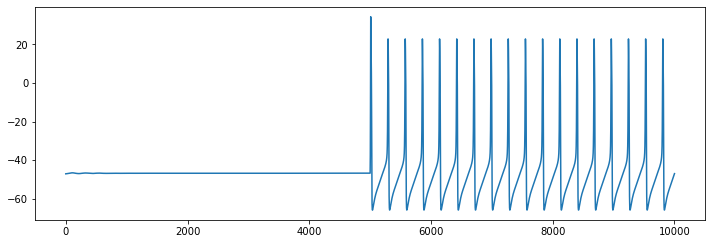

In [6]:
def t2rhs(Y,t):
    v,w = Y
    return[
        (P32(v,v0,v2)*L1(v,v0,a0,a1,0.)+I0*1.055-w**wp)/L1(v,v3,r0,r1,0.),
        (L2(v,v4,0.,v5,1.,0.,0.)-w)/S2(v,v6,v7,s0,s1,s2)
    ]
at = arange(0,10000,0.01)
res0 = odeint(t2rhs,[-47.,0.4]    ,at[:at.shape[0]//2])
res1 = odeint(t2rhs,[res0[-1,0],0.],at[at.shape[0]//2:])

f3 = figure(3, figsize=(12,18))
subplot2grid((4,2),(0,0),colspan=2)
plot(at,hstack((res0[:,0],res1[:,0])))
show()


## with linear adaptaion
$$
\begin{array}{rll}
L_1(v,v_3,r_0,r_1,0)       &\dot{v}&=P_{32}(v,v_0,v_2)L_1(v,v_0,a_0,a_1,0)+I-w^2 - z\\
S_2(v,v_6,,v_7,s_0,s_1,s_2)&\dot{w}&=L_2(v,v_4,0,v_5,1,0,0)-w \\
q_0                         &\dot{z}&=L_2(v,v_8,z_0,v_9,z_1,0,0)-z \\
\end{array}
$$

In [7]:
#--- z_\infty
v8,v9    = -35.,10.
z0,z1    = 0., 2.
#--- \tua_z
q0       = 500

In [8]:
def t1rhs(Y,t):
    v,w,z = Y
    return[
        (P32(v,v0,v2)*L1(v,v0,a0,a1,0.)+I1-w**wp-z)/L1(v,v3,r0,r1,0.),
        (L2(v,v4,0.,v5,1.,0.,0.)-w)/S2(v,v6,v7,s0,s1,s2),
        (L2(v,v8,z0,v9,z1,0.,0.)-z)/q0
    ]

at = arange(0,10000,0.01)
res = odeint(t1rhs,[v0,0,0.],at)

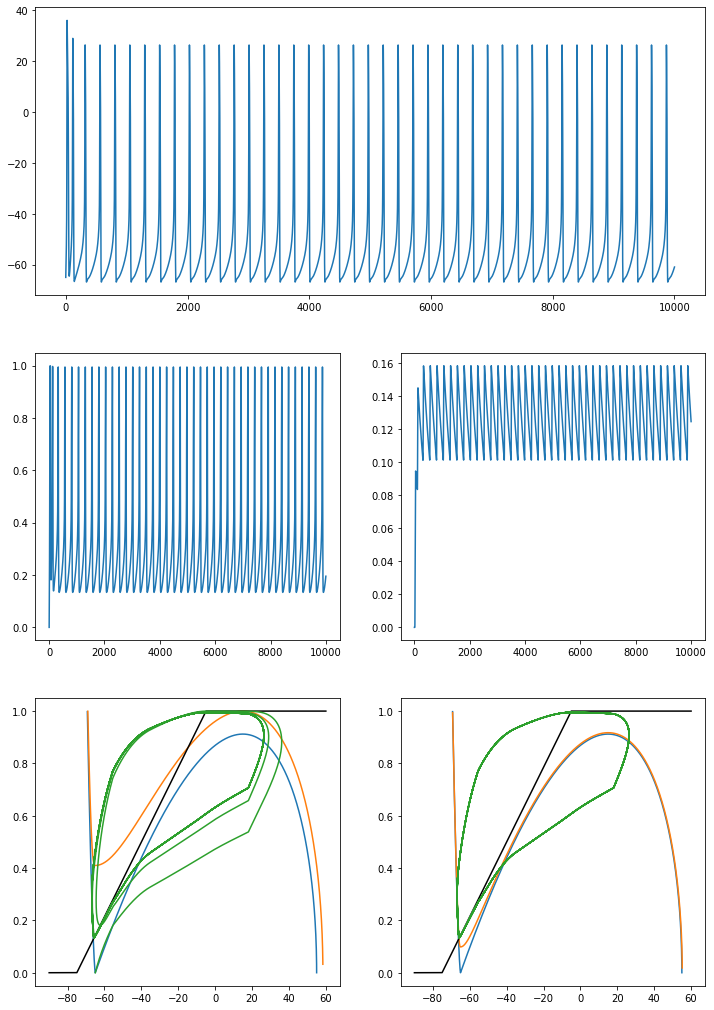

In [9]:
v0c   = safesqrt(vm, vectorize(P32)(vm,v0,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+0. ,1)
v0cI0 = safesqrt(vm, vectorize(P32)(vm,v0,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I1 ,1)
v0cI1 = safesqrt(vm, vectorize(P32)(vm,v0,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I1-amax(res[:,2]) ,1)


f2 = figure(2, figsize=(12,18))
subplot2grid((3,2),(0,0),colspan=2)
plot(at,res[:,0])
subplot2grid((3,2),(1,0))
plot(at,res[:,1])
subplot2grid((3,2),(1,1))
plot(at,res[:,2])
subplot2grid((3,2),(2,0))
plot(v0c[:,0],v0c[:,1])
plot(v0cI0[:,0],v0cI0[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[:200000,0],res[:200000,1])
subplot2grid((3,2),(2,1))
plot(v0c[:,0],v0c[:,1])
plot(v0cI1[:,0],v0cI1[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[-200000:,0],res[-200000:,1])
show()

## with non-linear adaptaion
$$
\begin{array}{rll}
L_1(v,v_3,r_0,r_1,0)       &\dot{v}&=P_{32}(v,v_0+z,v_2)L_1(v,v_0+z,a_0,a_1,0)+I-w^2\\
S_2(v,v_6,,v_7,s_0,s_1,s_2)&\dot{w}&=L_2(v,v_4,0,v_5,1,0,0)-w \\
q_0                         &\dot{z}&=L_2(v,v_8,z_0,v_9,z_1,0,0)-z \\
\end{array}
$$

In [10]:
#--- z_\infty
v8,v9    = -35.,10.
Delta    = 150
z0,z1    = 0,Delta
#--- \tua_z
q0       = 500

In [11]:
def t1rhs(Y,t):
    v,w,z = Y
    return[
        (P32(v,v0+z,v2)*L1(v,v0+z,a0,a1,0.)+I1-w**wp)/L1(v,v3,r0,r1,0.),
        (L2(v,v4,0.,v5,1.,0.,0.)-w)/S2(v,v6,v7,s0,s1,s2),
        (L2(v,v8,z0,v9,z1,0.,0.)-z)/q0
    ]

at = arange(0,10000,0.01)
res = odeint(t1rhs,[v0,0,0.],at)

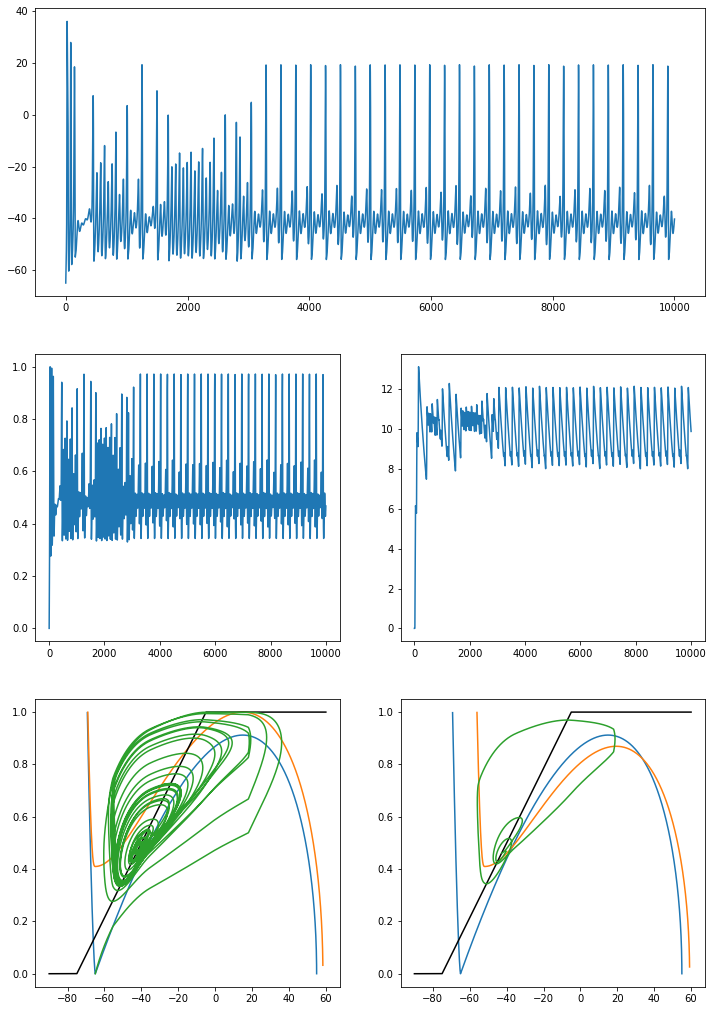

In [12]:
v0c   = safesqrt(vm, vectorize(P32)(vm,v0,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+0. ,1)
v0cI0 = safesqrt(vm, vectorize(P32)(vm,v0,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+I1 ,1)
zm    = amax(res[:,2])
v0cI1 = safesqrt(vm, vectorize(P32)(vm,v0+zm,v2)*vectorize(L1)(vm,v0+zm,a0,a1,0.)+I1 ,1)


f2 = figure(2, figsize=(12,18))
subplot2grid((3,2),(0,0),colspan=2)
plot(at,res[:,0])
subplot2grid((3,2),(1,0))
plot(at,res[:,1])
subplot2grid((3,2),(1,1))
plot(at,res[:,2])
subplot2grid((3,2),(2,0))
plot(v0c[:,0],v0c[:,1])
plot(v0cI0[:,0],v0cI0[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[:200000,0],res[:200000,1])
subplot2grid((3,2),(2,1))
plot(v0c[:,0],v0c[:,1])
plot(v0cI1[:,0],v0cI1[:,1])
plot(vm,vectorize(L2)(vm,v4,0.,v5,1.,0.,0.),"k-")
plot(res[-20000:,0],res[-20000:,1])

show()

## non biological adaptation
$$
\begin{array}{rll}
L_1(v,v_3,r_0,r_1,0)       &\dot{v}&=P_{32}(v,v_0,v_2)L_1(v,v_0,a_0,a_1,0)+I-w^2\\
S_2(v,v_6,,v_7,s_0,s_1,s_2)&\dot{w}&=L_2(v,v_4-z,0,v_5-z,1,0,0)-w \\
q_0                         &\dot{z}&=L_2(w,w_0,z_0,w_1,z_1,0,0)-z \\
\end{array}
$$

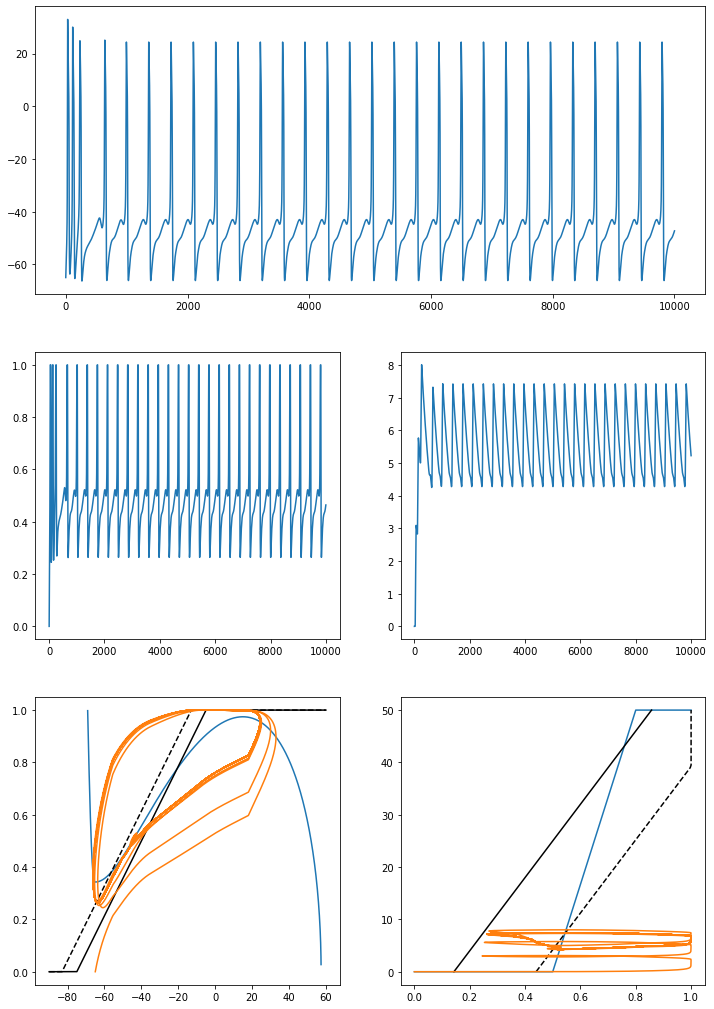

In [13]:
#--- z_\infty
w0,w1    = 0.5,0.8
Delta    = 50
z0,z1    = 0,Delta
#--- \tua_z
q0       = 500

Iapp     = I1*.7
def t1rhs(Y,t):
    v,w,z = Y
    return[
        (P32(v,v0,v2)*L1(v,v0,a0,a1,0.)+Iapp-w**wp)/L1(v,v3,r0,r1,0.),
        (L2(v,v4-z,0.,v5-z,1.,0.,0.)-w)/S2(v,v6,v7,s0,s1,s2),
        (L2(w,w0,z0,w1,z1,0.,0.)-z)/q0
    ]

at = arange(0,10000,0.01)
res = odeint(t1rhs,[v0,0,0.],at)

v0c   = safesqrt(vm, vectorize(P32)(vm,v0,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+0. ,1)
v0cI0 = safesqrt(vm, vectorize(P32)(vm,v0,v2)*vectorize(L1)(vm,v0,a0,a1,0.)+Iapp ,1)
zm    = amax(res[:,2])
wm    = linspace(0.,1., 101)
zy    = linspace(z0,z1, 101)
vmean = mean(res[:,0])



f2 = figure(2, figsize=(12,18))
subplot2grid((3,2),(0,0),colspan=2)
plot(at,res[:,0])
subplot2grid((3,2),(1,0))
plot(at,res[:,1])
subplot2grid((3,2),(1,1))
plot(at,res[:,2])
subplot2grid((3,2),(2,0))
plot(v0cI0[:,0],v0cI0[:,1])
plot(vm,vectorize(L2)(vm,v4   ,0.,v5   ,1.,0.,0.),"k-")
plot(vm,vectorize(L2)(vm,v4-zm,0.,v5-zm,1.,0.,0.),"k--")
plot(res[:,0],res[:,1])
subplot2grid((3,2),(2,1))
plot(wm,vectorize(L2)(wm,w0,z0,w1,z1,0.,0.))
plot(vectorize(L2)(v0   ,v4-zy,0.,v5-zy,1.,0.,0.),zy,'k-')
plot(vectorize(L2)(vmean,v4-zy,0.,v5-zy,1.,0.,0.),zy,'k--')
plot(res[:,1],res[:,2])

show()